In [3]:
from scipy.optimize import linprog
import seaborn as sns

from scipy.stats import kurtosis, skew
import pandas as pd
from rcv_distribution import *
from rcv_dimensionality import *
from voting_rules import *
import os

In [4]:
def calculate_intervals(numbers):
    midpoints = []
    for i in range(len(numbers)):
        for j in range(i + 1, len(numbers)):
            midpoints.append((numbers[i] + numbers[j])/2)

    intervals = []
    midpoints = sorted(midpoints)
    for i in range(len(midpoints)):
        for j in range(i + 1, len(midpoints)):
            intervals.append((midpoints[i], midpoints[j]))
    return midpoints, intervals

In [5]:
def ballot_to_num(ballot, normalized_distances):
    b_num = []
    for c in ballot:
        b_num.append(normalized_distances[c])
    return b_num

In [6]:
def solve_lp(b_num, midpoints, intervals, n):
    
    obj = [1]
    lhs_ineq = []
    rhs_ineq = []
    e = 0.000000001
    for i in range(len(b_num)):
        for j in range(i + 1, len(b_num)):
            mid = (b_num[i]+b_num[j])/2
            if (b_num[i] > b_num[j]):
                lhs_ineq.append([-1])
                rhs_ineq.append(-(e+mid))
            if (b_num[i] < b_num[j]):
                lhs_ineq.append([1])
                rhs_ineq.append(e+mid)
    bnd = [0, n-1]
    opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, bounds=bnd,
              method="revised simplex")
    return (opt["success"] is True)
        

    

In [7]:
def get_interval_consistent_points(ballots, normalized_distances):
    midpoints, intervals = calculate_intervals(list(normalized_distances.values()))

    total = 0
    consistent = 0
    consistent_ballots = {}
    for b in ballots:
        if (len(b) != 0):
            total += ballots[b]
            if (len(b) <= 2):
                consistent += ballots[b]
                consistent_ballots[b] = ballots[b]
            else:
                b_num = ballot_to_num(b, normalized_distances)
                lp = solve_lp(b_num, midpoints, intervals, len(normalized_distances))
                if (lp):
                    consistent_ballots[b] = ballots[b]
                    consistent += ballots[b]
    
    gamma = consistent/total
    return consistent_ballots, gamma
        

48


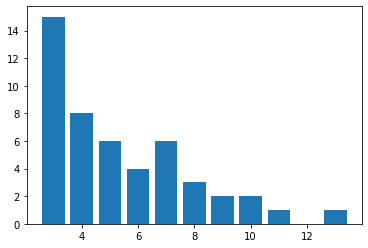

In [8]:
import matplotlib.pyplot as plt
df1 = pd.read_csv("interval_winners.csv")
df2 = pd.read_csv("strict_winners.csv")
data1 = {}
data2 = {}
count = 0
for index, row in df1.iterrows():
    if 'IRV' in row['diff']:
        count += 1
        if row['#candidates'] not in data1:
            data1[row['#candidates']] = 1
        else:
            data1[row['#candidates']] += 1
plt.bar(list(data1.keys()), data1.values())
print(count)




63


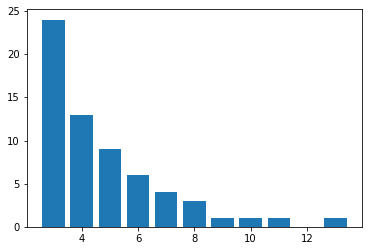

In [9]:
count = 0
data2 = {}
for index, row in df2.iterrows():
    if row['#candidates'] <= 15 and 'IRV' in row['diff']:
        count += 1
        if row['#candidates'] not in data2:
            data2[row['#candidates']] = 1
        else:
            data2[row['#candidates']] += 1
plt.bar(list(data2.keys()), data2.values())
print(count)

In [10]:
def get_bullet_votes(ballots):
    total = 0
    bullet = 0
    for b in ballots:
        if (len(b) > 0):
            total += ballots[b]
        if (len(b) == 1):
            bullet += ballots[b]
    return bullet/total

In [20]:
if ("Alaska_04102020_PRESIDENTOFTHEUNITEDSTATES.csv" in df1['filename'].values):
    print(df1['filename'].values)
print(df1['filename'][0])

yes
Alaska_04102020_PRESIDENTOFTHEUNITEDSTATES.csv


In [21]:
directory = "dataverse_files"
count = 0
for filename in os.listdir(directory):
    count += 1
    csv =  os.path.join(directory, filename)
    ballots, candidates = parse_election_data(csv)
    bullet_votes = get_bullet_votes(ballots)

    if (filename in df1['filename'].values):
        print(count, " ", filename, " ", bullet_votes)
        df1['bullet votes'] = bullet_votes
    if (filename in df2['filename'].values):
        df2['bullet votes'] = bullet_votes



1   Alaska_04102020_PRESIDENTOFTHEUNITEDSTATES.csv   0.198662749468139
2   Alaska_08162022_HouseofRepresentativesSpecial.csv   0.2968144367017559
3   Alaska_11082022_GovernorLieutenantGovernor.csv   0.3323666200325179
4   Alaska_11082022_HouseDistrict1.csv   0.7386957170571556
5   Alaska_11082022_HouseDistrict10.csv   0.5954097395909961
6   Alaska_11082022_HouseDistrict11.csv   0.5158223727047793
7   Alaska_11082022_HouseDistrict12.csv   0.7673450508788159
8   Alaska_11082022_HouseDistrict13.csv   0.7615176151761518
9   Alaska_11082022_HouseDistrict14.csv   0.7802564552959775
10   Alaska_11082022_HouseDistrict15.csv   0.5063273727647868
11   Alaska_11082022_HouseDistrict16.csv   0.7923006892963974
12   Alaska_11082022_HouseDistrict17.csv   0.48131455399061035
13   Alaska_11082022_HouseDistrict18.csv   0.4624823029731005
14   Alaska_11082022_HouseDistrict19.csv   0.48
15   Alaska_11082022_HouseDistrict2.csv   0.7739581871755297
16   Alaska_11082022_HouseDistrict20.csv   0.46241276171485

In [22]:
df1.to_csv("permissive_bullet.csv")
df2.to_csv("strict_bullet.csv")

In [6]:
winners = pd.DataFrame(columns=["filename", "diff", "interval gamma", "#candidates","IRV1", "Condorcet1", "Plurality1", "Approval1" "IRV2", "Condorcet2", "Plurality2", "Approval2"])
directory = "dataverse_files"
count = 0
for filename in os.listdir(directory):
    count += 1
    if (count % 50):
        print(count, " ", filename)
    try:
        csv =  os.path.join(directory, filename)
        ballots, candidates = parse_election_data(csv)

        # Perform the RCV analysis
        test = perform_rcv_analysis(csv, n_runs=1000)
        mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = test

        # Print the normalized distances between candidates and plot the MDS analysis
        normalized_distances = get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names)
        
        #running voting rules in the original election 
        org_election = voting_rules(ballots, candidates)
        irv1 = org_election.irv()
        condorcet1 = org_election.condorcet()
        plurality1 = org_election.plurality()
        approval1 = org_election.approval()

        #getting consistent ballots using the interval approach
        consistent_ballots, gamma = get_interval_consistent_points(ballots, normalized_distances)
        
        #running voting rules on only consistent ballots
        election = voting_rules(consistent_ballots, candidates)
        irv2 = election.irv()
        condorcet2 = election.condorcet()
        plurality2 = election.plurality()
        approval2 = election.approval()

        diff = []
        if (irv1 != irv2):
            diff.append("IRV")
        if (condorcet1 != condorcet2):
            diff.append("Condorcet")
        if (plurality1 != plurality2):
            diff.append("Plurality")
        if (approval1 != approval2):
            diff.append("Approval")
        winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
                                'Plurality1': plurality1, 'Approval1': approval1,
                                'IRV2': irv2, "Condorcet2": condorcet2, 
                                'Plurality2':plurality2, 'Approval2': approval2}, ignore_index=True)


    except:
        print(filename, " threw an exception")
winners.to_csv('interval_winners.csv', index=False)
    

1   Alaska_04102020_PRESIDENTOFTHEUNITEDSTATES.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


2   Alaska_08162022_HouseofRepresentativesSpecial.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


3   Alaska_11082022_GovernorLieutenantGovernor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


4   Alaska_11082022_HouseDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


5   Alaska_11082022_HouseDistrict10.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


6   Alaska_11082022_HouseDistrict11.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


7   Alaska_11082022_HouseDistrict12.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


8   Alaska_11082022_HouseDistrict13.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


9   Alaska_11082022_HouseDistrict14.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


10   Alaska_11082022_HouseDistrict15.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


11   Alaska_11082022_HouseDistrict16.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


12   Alaska_11082022_HouseDistrict17.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


13   Alaska_11082022_HouseDistrict18.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


14   Alaska_11082022_HouseDistrict19.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


15   Alaska_11082022_HouseDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


16   Alaska_11082022_HouseDistrict20.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


17   Alaska_11082022_HouseDistrict21.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


18   Alaska_11082022_HouseDistrict22.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


19   Alaska_11082022_HouseDistrict23.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


20   Alaska_11082022_HouseDistrict24.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


21   Alaska_11082022_HouseDistrict25.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


22   Alaska_11082022_HouseDistrict26.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


23   Alaska_11082022_HouseDistrict27.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


24   Alaska_11082022_HouseDistrict28.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


25   Alaska_11082022_HouseDistrict29.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


26   Alaska_11082022_HouseDistrict3.csv
Alaska_11082022_HouseDistrict3.csv  threw an exception
27   Alaska_11082022_HouseDistrict30.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


28   Alaska_11082022_HouseDistrict31.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


29   Alaska_11082022_HouseDistrict32.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


30   Alaska_11082022_HouseDistrict33.csv
Alaska_11082022_HouseDistrict33.csv  threw an exception
31   Alaska_11082022_HouseDistrict34.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


32   Alaska_11082022_HouseDistrict35.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


33   Alaska_11082022_HouseDistrict36.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


34   Alaska_11082022_HouseDistrict37.csv
Alaska_11082022_HouseDistrict37.csv  threw an exception
35   Alaska_11082022_HouseDistrict38.csv
Alaska_11082022_HouseDistrict38.csv  threw an exception
36   Alaska_11082022_HouseDistrict39.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


37   Alaska_11082022_HouseDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


38   Alaska_11082022_HouseDistrict40.csv
Alaska_11082022_HouseDistrict40.csv  threw an exception
39   Alaska_11082022_HouseDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


40   Alaska_11082022_HouseDistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


41   Alaska_11082022_HouseDistrict7.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


42   Alaska_11082022_HouseDistrict8.csv
Alaska_11082022_HouseDistrict8.csv  threw an exception
43   Alaska_11082022_HouseDistrict9.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


44   Alaska_11082022_SenateDistrictA.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


45   Alaska_11082022_SenateDistrictB.csv
Alaska_11082022_SenateDistrictB.csv  threw an exception
46   Alaska_11082022_SenateDistrictC.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


47   Alaska_11082022_SenateDistrictD.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


48   Alaska_11082022_SenateDistrictE.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


49   Alaska_11082022_SenateDistrictF.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': fil

51   Alaska_11082022_SenateDistrictH.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


52   Alaska_11082022_SenateDistrictI.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


53   Alaska_11082022_SenateDistrictJ.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


54   Alaska_11082022_SenateDistrictK.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


55   Alaska_11082022_SenateDistrictL.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


56   Alaska_11082022_SenateDistrictM.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


57   Alaska_11082022_SenateDistrictN.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


58   Alaska_11082022_SenateDistrictO.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


59   Alaska_11082022_SenateDistrictP.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


60   Alaska_11082022_SenateDistrictQ.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


61   Alaska_11082022_SenateDistrictR.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


62   Alaska_11082022_SenateDistrictS.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


63   Alaska_11082022_USRepresentative.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


64   Alaska_11082022_USSenator.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


65   Albany_11082022_BoardofEducation.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


66   Albany_11082022_CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


67   Albany_11082022_FAKECityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


68   Berkeley_03072017_CityCouncilDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


69   Berkeley_11022010_CityAuditor.csv
Berkeley_11022010_CityAuditor.csv  threw an exception
70   Berkeley_11022010_CityCouncilDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


71   Berkeley_11022010_CityCouncilDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


72   Berkeley_11022010_CityCouncilDistrict7.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


73   Berkeley_11022010_CityCouncilDistrict8.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


74   Berkeley_11032020_MayorBerkeleyRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


75   Berkeley_11032020_MemberCityCouncilDist2BerkeleyRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


76   Berkeley_11032020_MemberCityCouncilDist3BerkeleyRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


77   Berkeley_11032020_MemberCityCouncilDist5BerkeleyRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


78   Berkeley_11032020_MemberCityCouncilDist6BerkeleyRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


79   Berkeley_11042014_CityAuditor.csv
Berkeley_11042014_CityAuditor.csv  threw an exception
80   Berkeley_11042014_CityCouncilDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


81   Berkeley_11042014_CityCouncilDistrict7.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


82   Berkeley_11042014_CityCouncilDistrict8.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


83   Berkeley_11062012_CityCouncilDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


84   Berkeley_11062012_CityCouncilDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


85   Berkeley_11062012_CityCouncilDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


86   Berkeley_11062012_CityCouncilDistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


87   Berkeley_11062012_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


88   Berkeley_11062018_CityAuditor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


89   Berkeley_11062018_CityCouncilDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


90   Berkeley_11062018_CityCouncilDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


91   Berkeley_11062018_CityCouncilDistrict7.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


92   Berkeley_11062018_CityCouncilDistrict8.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


93   Berkeley_11082016_CityCouncilDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


94   Berkeley_11082016_CityCouncilDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


95   Berkeley_11082016_CityCouncilDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


96   Berkeley_11082016_CityCouncilDistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


97   Berkeley_11082016_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


98   Burlington_03032009_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


99   Burlington_03072006_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': fil

101   Burlington_03072023_CityCouncilEastDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


102   Burlington_03072023_CityCouncilNorthDistrict.csv
Burlington_03072023_CityCouncilNorthDistrict.csv  threw an exception
103   Burlington_03072023_CityCouncilSouthDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


104   Corvallis_11082022_CityCouncilWard9.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


105   Corvallis_11082022_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


106   Easthampton_11022021_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: divide by zero encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: invalid value encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


107   Eastpointe_11052019_CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


108   ElkRidge_11022021_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


109   Hawaii_05232020_PresidentoftheUnitedStateCD1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


110   Hawaii_05232020_PresidentoftheUnitedStateCD1CD2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


111   Hawaii_05232020_PresidentoftheUnitedStateCD2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


112   Kansas_05022020_PRESIDENTOFTHEUNITEDSTATES.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


113   LasCruces_11052019_COUNCILORPOSITION2CITYOFLASCRUCESDISTRICT2COUNCILOR.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


114   LasCruces_11052019_COUNCILORPOSITION4CITYOFLASCRUCESDISTRICT4COUNCILOR.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


115   LasCruces_11052019_MAYORCITYOFLASCRUCES.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


116   Maine_06122018_DemocraticPrimaryforCD2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


117   Maine_06122018_DemocraticPrimaryforGovernor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


118   Maine_07142020_DemocraticCandidateforMaineStateHouseDistrict41.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


119   Maine_07142020_DemocraticCandidateforMaineStateHouseDistrict47.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


120   Maine_07142020_DemocraticCandidateforMaineStateHouseDistrict49.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


121   Maine_07142020_DemocraticCandidateforMaineStateHouseDistrict90.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


122   Maine_07142020_DemocraticCandidateforMaineStateSenateDistrict11.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


123   Maine_07142020_RepublicanCandidateforUSHouseofRepresentativesDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


124   Maine_11062018_CongressionalDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


125   Maine_11082022_CongressionalDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


126   Minneapolis_08112020_Ward6CityCouncilSpecialElection.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


127   Minneapolis_11022021_CityCouncilWard1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


128   Minneapolis_11022021_CityCouncilWard10.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


129   Minneapolis_11022021_CityCouncilWard11.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


130   Minneapolis_11022021_CityCouncilWard12.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


131   Minneapolis_11022021_CityCouncilWard13.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


132   Minneapolis_11022021_CityCouncilWard2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


133   Minneapolis_11022021_CityCouncilWard3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


134   Minneapolis_11022021_CityCouncilWard4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


135   Minneapolis_11022021_CityCouncilWard5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


136   Minneapolis_11022021_CityCouncilWard6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


137   Minneapolis_11022021_CityCouncilWard7.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


138   Minneapolis_11022021_CityCouncilWard8.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


139   Minneapolis_11022021_CityCouncilWard9.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


140   Minneapolis_11022021_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: divide by zero encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: invalid value encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


141   Minneapolis_11022021_ParkBoardAtLarge.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


142   Minneapolis_11022021_ParkBoardDistrict1.csv
Minneapolis_11022021_ParkBoardDistrict1.csv  threw an exception
143   Minneapolis_11022021_ParkBoardDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


144   Minneapolis_11022021_ParkBoardDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


145   Minneapolis_11022021_ParkBoardDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


146   Minneapolis_11022021_ParkBoardDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


147   Minneapolis_11022021_ParkBoardDistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


148   Minneapolis_11052013_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: divide by zero encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


149   Minneapolis_11052013_PRBoardDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': fil

151   Minneapolis_11052013_Ward13CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


152   Minneapolis_11052013_Ward5CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


153   Minneapolis_11052013_Ward9CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


154   Minneapolis_11062009_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


155   Minneapolis_11062009_PRBoardDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


156   Minneapolis_11062009_PRBoardDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


157   Minneapolis_11062009_PRBoardDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


158   Minneapolis_11062009_PRBoardDistrict4.csv
Minneapolis_11062009_PRBoardDistrict4.csv  threw an exception
159   Minneapolis_11062009_PRBoardDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


160   Minneapolis_11062009_PRBoardDistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


161   Minneapolis_11062009_Ward10CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


162   Minneapolis_11062009_Ward11CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


163   Minneapolis_11062009_Ward12CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


164   Minneapolis_11062009_Ward13CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


165   Minneapolis_11062009_Ward1CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


166   Minneapolis_11062009_Ward2CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


167   Minneapolis_11062009_Ward3CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


168   Minneapolis_11062009_Ward4CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


169   Minneapolis_11062009_Ward5CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


170   Minneapolis_11062009_Ward6CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


171   Minneapolis_11062009_Ward7CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


172   Minneapolis_11062009_Ward8CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


173   Minneapolis_11062009_Ward9CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


174   Minneapolis_11072017_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: divide by zero encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: invalid value encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


175   Minneapolis_11072017_PRBoardDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


176   Minneapolis_11072017_PRBoardDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


177   Minneapolis_11072017_PRBoardDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


178   Minneapolis_11072017_PRBoardDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


179   Minneapolis_11072017_PRBoardDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


180   Minneapolis_11072017_PRBoardDistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


181   Minneapolis_11072017_Ward10CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


182   Minneapolis_11072017_Ward11CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


183   Minneapolis_11072017_Ward12CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


184   Minneapolis_11072017_Ward13CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


185   Minneapolis_11072017_Ward1CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


186   Minneapolis_11072017_Ward2CityCouncil.csv
Minneapolis_11072017_Ward2CityCouncil.csv  threw an exception
187   Minneapolis_11072017_Ward3CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


188   Minneapolis_11072017_Ward4CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


189   Minneapolis_11072017_Ward5CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


190   Minneapolis_11072017_Ward6CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


191   Minneapolis_11072017_Ward7CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


192   Minneapolis_11072017_Ward8CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


193   Minneapolis_11072017_Ward9CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


194   Minnetonka_11022021_CityCouncilAtLargeSeatA.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


195   Minnetonka_11022021_CityCouncilAtLargeSeatB.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


196   Minnetonka_11022021_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


197   NewYorkCity_06222021_CONCouncilMember19thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


198   NewYorkCity_06222021_DEMBoroughPresidentBronx.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


199   NewYorkCity_06222021_DEMBoroughPresidentKings.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': fil

201   NewYorkCity_06222021_DEMBoroughPresidentQueens.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


202   NewYorkCity_06222021_DEMBoroughPresidentRichmond.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


203   NewYorkCity_06222021_DEMComptrollerCitywide.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


204   NewYorkCity_06222021_DEMCouncilMember10thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


205   NewYorkCity_06222021_DEMCouncilMember11thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


206   NewYorkCity_06222021_DEMCouncilMember12thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


207   NewYorkCity_06222021_DEMCouncilMember13thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


208   NewYorkCity_06222021_DEMCouncilMember14thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


209   NewYorkCity_06222021_DEMCouncilMember15thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


210   NewYorkCity_06222021_DEMCouncilMember16thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


211   NewYorkCity_06222021_DEMCouncilMember17thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


212   NewYorkCity_06222021_DEMCouncilMember18thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


213   NewYorkCity_06222021_DEMCouncilMember19thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


214   NewYorkCity_06222021_DEMCouncilMember1stCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


215   NewYorkCity_06222021_DEMCouncilMember20thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


216   NewYorkCity_06222021_DEMCouncilMember21stCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


217   NewYorkCity_06222021_DEMCouncilMember22ndCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


218   NewYorkCity_06222021_DEMCouncilMember23rdCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


219   NewYorkCity_06222021_DEMCouncilMember24thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


220   NewYorkCity_06222021_DEMCouncilMember25thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


221   NewYorkCity_06222021_DEMCouncilMember26thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


222   NewYorkCity_06222021_DEMCouncilMember27thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


223   NewYorkCity_06222021_DEMCouncilMember28thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


224   NewYorkCity_06222021_DEMCouncilMember29thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


225   NewYorkCity_06222021_DEMCouncilMember2ndCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


226   NewYorkCity_06222021_DEMCouncilMember30thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


227   NewYorkCity_06222021_DEMCouncilMember31stCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


228   NewYorkCity_06222021_DEMCouncilMember32ndCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


229   NewYorkCity_06222021_DEMCouncilMember33rdCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


230   NewYorkCity_06222021_DEMCouncilMember34thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


231   NewYorkCity_06222021_DEMCouncilMember35thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


232   NewYorkCity_06222021_DEMCouncilMember36thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


233   NewYorkCity_06222021_DEMCouncilMember37thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


234   NewYorkCity_06222021_DEMCouncilMember38thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


235   NewYorkCity_06222021_DEMCouncilMember39thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


236   NewYorkCity_06222021_DEMCouncilMember3rdCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


237   NewYorkCity_06222021_DEMCouncilMember40thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


238   NewYorkCity_06222021_DEMCouncilMember41stCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


239   NewYorkCity_06222021_DEMCouncilMember42ndCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


240   NewYorkCity_06222021_DEMCouncilMember45thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


241   NewYorkCity_06222021_DEMCouncilMember46thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


242   NewYorkCity_06222021_DEMCouncilMember47thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


243   NewYorkCity_06222021_DEMCouncilMember48thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


244   NewYorkCity_06222021_DEMCouncilMember49thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


245   NewYorkCity_06222021_DEMCouncilMember5thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


246   NewYorkCity_06222021_DEMCouncilMember6thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


247   NewYorkCity_06222021_DEMCouncilMember7thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


248   NewYorkCity_06222021_DEMCouncilMember8thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


249   NewYorkCity_06222021_DEMCouncilMember9thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': fil

251   NewYorkCity_06222021_DEMPublicAdvocateCitywide.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


252   NewYorkCity_06222021_REPBoroughPresidentQueens.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


253   NewYorkCity_06222021_REPBoroughPresidentRichmond.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


254   NewYorkCity_06222021_REPCouncilMember15thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


255   NewYorkCity_06222021_REPCouncilMember19thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


256   NewYorkCity_06222021_REPCouncilMember23rdCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


257   NewYorkCity_06222021_REPCouncilMember24thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


258   NewYorkCity_06222021_REPCouncilMember32ndCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


259   NewYorkCity_06222021_REPCouncilMember50thCouncilDistrict.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


260   NewYorkCity_06222021_REPMayorCitywide.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


261   Oakland_11022010_CityAuditor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


262   Oakland_11022010_CityCouncilDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


263   Oakland_11022010_CityCouncilDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


264   Oakland_11022010_CityCouncilDistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


265   Oakland_11022010_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


266   Oakland_11022010_SchoolDirectorDistrict2.csv
Oakland_11022010_SchoolDirectorDistrict2.csv  threw an exception
267   Oakland_11022010_SchoolDirectorDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


268   Oakland_11022010_SchoolDirectorDistrict6.csv
Oakland_11022010_SchoolDirectorDistrict6.csv  threw an exception
269   Oakland_11032020_CityAttorneyOaklandRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


270   Oakland_11032020_MemberCityCouncilAtLargeOaklandRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


271   Oakland_11032020_MemberCityCouncilDist1OaklandRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


272   Oakland_11032020_MemberCityCouncilDist3OaklandRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


273   Oakland_11032020_MemberCityCouncilDist5OaklandRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


274   Oakland_11032020_MemberCityCouncilDist7OaklandRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


275   Oakland_11032020_SchoolDirectorDist1OaklandRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


276   Oakland_11032020_SchoolDirectorDist3OaklandRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


277   Oakland_11032020_SchoolDirectorDist5OaklandRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


278   Oakland_11032020_SchoolDirectorDist7OaklandRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


279   Oakland_11042014_CityAuditor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


280   Oakland_11042014_CityCouncilDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


281   Oakland_11042014_CityCouncilDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


282   Oakland_11042014_CityCouncilDistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


283   Oakland_11042014_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: divide by zero encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


284   Oakland_11042014_SchoolDirectorDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


285   Oakland_11042014_SchoolDirectorDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


286   Oakland_11042014_SchoolDirectorDistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


287   Oakland_11062012_CityAttorney.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


288   Oakland_11062012_CityCouncilAtLarge.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


289   Oakland_11062012_CityCouncilDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


290   Oakland_11062012_CityCouncilDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


291   Oakland_11062012_CityCouncilDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


292   Oakland_11062012_CityCouncilDistrict7.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


293   Oakland_11062012_SchoolDirectorDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


294   Oakland_11062012_SchoolDirectorDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


295   Oakland_11062012_SchoolDirectorDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


296   Oakland_11062012_SchoolDirectorDistrict7.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


297   Oakland_11062018_CityAuditor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


298   Oakland_11062018_CityCouncilDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


299   Oakland_11062018_CityCouncilDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': fil

301   Oakland_11062018_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


302   Oakland_11062018_SchoolDirectorDistrict2.csv
Oakland_11062018_SchoolDirectorDistrict2.csv  threw an exception
303   Oakland_11062018_SchoolDirectorDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


304   Oakland_11062018_SchoolDirectorDistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


305   Oakland_11082016_CityAttorney.csv
Oakland_11082016_CityAttorney.csv  threw an exception
306   Oakland_11082016_CityCouncilDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


307   Oakland_11082016_CityCouncilDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


308   Oakland_11082016_CityCouncilDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


309   Oakland_11082016_CityCouncilDistrict7.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


310   Oakland_11082016_CouncilAtLrg.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


311   Oakland_11082016_SchoolDirectorDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


312   Oakland_11082016_SchoolDirectorDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


313   Oakland_11082016_SchoolDirectorDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


314   Oakland_11082016_SchoolDirectorDistrict7.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


315   Oakland_11082022_CityAuditor.csv
Oakland_11082022_CityAuditor.csv  threw an exception
316   Oakland_11082022_CityCouncilmemberDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


317   Oakland_11082022_CityCouncilmemberDistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


318   Oakland_11082022_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


319   Oakland_11082022_Schoolboarddistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


320   Oakland_11082022_Schoolboarddistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


321   Oakland_11082022_Schoolboarddistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


322   Payson_11052019_CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


323   PierceCounty_11032009_CountyAuditor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


324   PierceCounty_11042008_CountyAssessorTreasurer.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


325   PierceCounty_11042008_CountyCouncilDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


326   PierceCounty_11042008_CountyExecutiveMember.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


327   Portland_06082021_charter_commission_at_large.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


328   Portland_06142022_SchoolboardAL-1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


329   Portland_06142022_SchoolboardAL.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: divide by zero encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: invalid value encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


330   Portland_06142022_Schoolboarddistrict5-1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


331   Portland_06142022_Schoolboarddistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: divide by zero encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: invalid value encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


332   Portland_11082022_SchoolBoardDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


333   SanFrancisco_06052018_BoardofSupervisorsDistrict8.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


334   SanFrancisco_06052018_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


335   SanFrancisco_11022004_BoardofSupervisorsDistrict11.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


336   SanFrancisco_11022004_BoardofSupervisorsDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


337   SanFrancisco_11022004_BoardofSupervisorsDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


338   SanFrancisco_11022004_BoardofSupervisorsDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


339   SanFrancisco_11022004_BoardofSupervisorsDistrict7.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


340   SanFrancisco_11022004_BoardofSupervisorsDistrict9.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


341   SanFrancisco_11022010_BoardofSupervisorsDistrict10.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


342   SanFrancisco_11022010_BoardofSupervisorsDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


343   SanFrancisco_11022010_BoardofSupervisorsDistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


344   SanFrancisco_11022010_BoardofSupervisorsDistrict8.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


345   SanFrancisco_11032015_BoardofSupervisorsDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


346   SanFrancisco_11032015_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


347   SanFrancisco_11032015_Sheriff.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


348   SanFrancisco_11032020_BOARDOFSUPERVISORSDISTRICT1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


349   SanFrancisco_11032020_BOARDOFSUPERVISORSDISTRICT11.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': fil

351   SanFrancisco_11032020_BOARDOFSUPERVISORSDISTRICT5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


352   SanFrancisco_11032020_BOARDOFSUPERVISORSDISTRICT7.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


353   SanFrancisco_11032020_BOARDOFSUPERVISORSDISTRICT9.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


354   SanFrancisco_11042008_BoardofSupervisorsDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


355   SanFrancisco_11042008_BoardofSupervisorsDistrict11.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: divide by zero encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: invalid value encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


356   SanFrancisco_11042008_BoardofSupervisorsDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


357   SanFrancisco_11042008_BoardofSupervisorsDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


358   SanFrancisco_11042008_BoardofSupervisorsDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


359   SanFrancisco_11042008_BoardofSupervisorsDistrict7.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


360   SanFrancisco_11042008_BoardofSupervisorsDistrict9.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


361   SanFrancisco_11042014_BoardofSupervisorsDistrict10.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


362   SanFrancisco_11052004_BoardofSupervisorsDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


363   SanFrancisco_11052019_CityAttorney.csv
SanFrancisco_11052019_CityAttorney.csv  threw an exception
364   SanFrancisco_11052019_DistrictAttorney.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


365   SanFrancisco_11052019_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


366   SanFrancisco_11052019_MemberBoardofSupervisorsDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


367   SanFrancisco_11052019_PublicDefender.csv
SanFrancisco_11052019_PublicDefender.csv  threw an exception
368   SanFrancisco_11052019_Sheriff.csv
SanFrancisco_11052019_Sheriff.csv  threw an exception
369   SanFrancisco_11052019_Treasurer.csv
SanFrancisco_11052019_Treasurer.csv  threw an exception
370   SanFrancisco_11062007_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


371   SanFrancisco_11062012_BoardofSupervisorsDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


372   SanFrancisco_11062012_BoardofSupervisorsDistrict7.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


373   SanFrancisco_11062018_AssessorRecorder.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


374   SanFrancisco_11062018_BoardofSupervisorsDistrict10.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


375   SanFrancisco_11062018_BoardofSupervisorsDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


376   SanFrancisco_11062018_BoardofSupervisorsDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


377   SanFrancisco_11062018_BoardofSupervisorsDistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


378   SanFrancisco_11062018_BoardofSupervisorsDistrict8.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


379   SanFrancisco_11062018_PublicDefender.csv
SanFrancisco_11062018_PublicDefender.csv  threw an exception
380   SanFrancisco_11072006_BoardofSupervisorsDistrict10.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


381   SanFrancisco_11072006_BoardofSupervisorsDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


382   SanFrancisco_11072006_BoardofSupervisorsDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


383   SanFrancisco_11072006_BoardofSupervisorsDistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


384   SanFrancisco_11072006_BoardofSupervisorsDistrict8.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


385   SanFrancisco_11082005_AssessorRecorder.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


386   SanFrancisco_11082005_Treasurer.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


387   SanFrancisco_11082011_DistrictAttorney.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


388   SanFrancisco_11082011_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


389   SanFrancisco_11082011_Sheriff.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


390   SanFrancisco_11082016_BoardofSupervisorsDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


391   SanFrancisco_11082016_BoardofSupervisorsDistrict11.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


392   SanFrancisco_11082016_BoardofSupervisorsDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


393   SanFrancisco_11082016_BoardofSupervisorsDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


394   SanFrancisco_11082016_BoardofSupervisorsDistrict7.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


395   SanFrancisco_11082016_BoardofSupervisorsDistrict9.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


396   SanFrancisco_11082022_AssessorRecorder.csv
SanFrancisco_11082022_AssessorRecorder.csv  threw an exception
397   SanFrancisco_11082022_BoardofSupervisorsD10.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


398   SanFrancisco_11082022_BoardofSupervisorsD2.csv
SanFrancisco_11082022_BoardofSupervisorsD2.csv  threw an exception
399   SanFrancisco_11082022_BoardofSupervisorsD4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': fil

401   SanFrancisco_11082022_BoardofSupervisorsD8.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


402   SanFrancisco_11082022_DistrictAttorney.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


403   SanFrancisco_11082022_PublicDefender.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


404   SanLeandro_11022010_CountyCouncilDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


405   SanLeandro_11022010_CountyCouncilDistrict3.csv
SanLeandro_11022010_CountyCouncilDistrict3.csv  threw an exception
406   SanLeandro_11022010_CountyCouncilDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


407   SanLeandro_11022010_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: divide by zero encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


408   SanLeandro_11032020_MemberCityCouncilDist2SanLeandroRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


409   SanLeandro_11032020_MemberCityCouncilDist4SanLeandroRCV.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


410   SanLeandro_11032020_MemberCityCouncilDist6SanLeandroRCV.csv
SanLeandro_11032020_MemberCityCouncilDist6SanLeandroRCV.csv  threw an exception
411   SanLeandro_11042014_CountyCouncilDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


412   SanLeandro_11042014_CountyCouncilDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


413   SanLeandro_11042014_CountyCouncilDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


414   SanLeandro_11042014_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


415   SanLeandro_11062012_CountyCouncilDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


416   SanLeandro_11062012_CountyCouncilDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


417   SanLeandro_11062012_CountyCouncilDistrict6.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


418   SanLeandro_11062018_CountyCouncilDistrict1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


419   SanLeandro_11062018_CountyCouncilDistrict3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


420   SanLeandro_11062018_CountyCouncilDistrict5.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


421   SanLeandro_11062018_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


422   SanLeandro_11082016_CountyCouncilDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


423   SanLeandro_11082016_CountyCouncilDistrict4.csv
SanLeandro_11082016_CountyCouncilDistrict4.csv  threw an exception
424   SanLeandro_11082016_CountyCouncilDistrict6.csv
SanLeandro_11082016_CountyCouncilDistrict6.csv  threw an exception
425   SantaFe_03062018_CityCouncilDistrict2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


426   SantaFe_03062018_CityCouncilDistrict4.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


427   SantaFe_03062018_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


428   Springville_11022021_CityCouncil2yr.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


429   Springville_11022021_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


430   StLouisPark_11022021_CityCouncilWard1.csv
StLouisPark_11022021_CityCouncilWard1.csv  threw an exception
431   StLouisPark_11022021_CityCouncilWard2.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


432   StLouisPark_11022021_CityCouncilWard3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


433   StLouisPark_11022021_CityCouncilWard4.csv
StLouisPark_11022021_CityCouncilWard4.csv  threw an exception
434   TakomaPark_11082022_CityCouncilWard1.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


435   TakomaPark_11082022_CityCouncilWard2.csv
TakomaPark_11082022_CityCouncilWard2.csv  threw an exception
436   TakomaPark_11082022_CityCouncilWard3.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: divide by zero encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: invalid value encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EI

437   TakomaPark_11082022_CityCouncilWard4.csv
TakomaPark_11082022_CityCouncilWard4.csv  threw an exception
438   TakomaPark_11082022_CityCouncilWard5.csv


C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: divide by zero encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: invalid value encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)


439   TakomaPark_11082022_CityCouncilWard6.csv


C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


440   TakomaPark_11082022_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: divide by zero encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:159: RuntimeWarning: invalid value encountered in true_divide
  frequencies = counts / mentioned_together
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


441   Vineyard_11022021_Mayor.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


442   Vineyard_11052019_CityCouncil.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)


443   WoodlandHills_11022021_Mayor.csv


C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


444   Wyoming_04172020_PRESIDENTOFTHEUNITEDSTATES.csv


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\EIL summer 2023\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)
C:\Users\mahsh\AppData\Local\Temp\ipykernel_19644\1022061950.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "interval gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


In [7]:
print(winners)

                                              filename diff interval gamma  \
0       Alaska_04102020_PRESIDENTOFTHEUNITEDSTATES.csv   []        0.82544   
1    Alaska_08162022_HouseofRepresentativesSpecial.csv   []        0.82544   
2       Alaska_11082022_GovernorLieutenantGovernor.csv   []        0.82544   
3                   Alaska_11082022_HouseDistrict1.csv   []        0.82544   
4                  Alaska_11082022_HouseDistrict10.csv   []        0.82544   
..                                                 ...  ...            ...   
439                      TakomaPark_11082022_Mayor.csv   []        0.82544   
440                        Vineyard_11022021_Mayor.csv   []        0.82544   
441                  Vineyard_11052019_CityCouncil.csv   []        0.82544   
442                   WoodlandHills_11022021_Mayor.csv   []        0.82544   
443    Wyoming_04172020_PRESIDENTOFTHEUNITEDSTATES.csv   []        0.82544   

    #candidates           IRV1     Condorcet1     Plurality1 Ap